In [172]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simple representation space tests with an FCN

Genetic circuits can be designed with qualitative output behavior in mind. While the quantitative measurements relating to the circuits can be helpful, optimising for specific output values may be unfeasible because of the high dimensionality that genetic circuit space can embody. Furthermore, in many instances, a range of output values or those achieving a certain threshold are also ok. In this notebook, we will explore neural networks as a means for multi-purpose and multi-dimensional optimisation. We will use the embedding space as a way to find circuits that match a specific specification.

## Imports

In [173]:
from typing import Optional, List, Callable, Dict, Any, Tuple
from dataclasses import dataclass

import haiku as hk
import jax
import jax.numpy as jnp
from jaxtyping import Float, Array, Int
import numpy as np
import pandas as pd

import equinox as eqx

import seaborn as sns
import matplotlib.pyplot as plt
jax.config.update('jax_platform_name', 'cpu')
from synbio_morpher.utils.misc.string_handling import convert_liststr_to_list
from synbio_morpher.utils.misc.type_handling import flatten_listlike
from synbio_morpher.utils.results.analytics.naming import get_true_names_analytics


In [174]:

def cross_entropy_loss(x):
    return 1


def loss_func(x, y):
    return cross_entropy_loss(x)


def compute_grads(params, x, y, model):
    logits, outs = model.apply(params, None, x)
    return loss_func(logits, y), outs


def update(params, grads, lr=0.1):
    return jax.tree_util.tree_map(lambda p, g: p - g * lr, params, grads)


def train_step(params, x, y, model):
    params_grads, outs = jax.grad(compute_grads)(params, x, y, model)
    return update(params, params_grads), outs


def train(iterations: int, batchsize: int, params: jnp.ndarray, xdata: jnp.ndarray, ydata: jnp.ndarray, model, 
          save_params: Optional[jnp.ndarray] = None, save_outs: Optional[jnp.ndarray] = None):
    all_params = {}
    all_outs = {}
    for i in range(iterations):
        # for b in range(batchsize):
            # x = xdata[bi:bf]
        params, outs = train_step(params, xdata, ydata, model)
        if i in save_params:
            all_params[i] = save_params
        if i in save_outs:
            all_outs[i] = outs
    return params, outs

## Patrick's Equinox CNN


In [198]:
class CNN(eqx.Module):
    layers: list

    def __init__(self, key, n_channels: int, n_head: int):
        key1, key2, key3, key4 = jax.random.split(key, 4)
        # Standard CNN setup: convolutional layer, followed by flattening,
        # with a small MLP on top.
        self.layers = [
            eqx.nn.Conv2d(n_channels, 3, kernel_size=4, key=key1),
            eqx.nn.MaxPool2d(kernel_size=2, stride=1),
            jax.nn.relu,
            jnp.ravel,
            eqx.nn.Linear(1728, 512, key=key2),
            jax.nn.sigmoid,
            eqx.nn.Linear(512, 64, key=key3),
            jax.nn.relu,
            eqx.nn.Linear(64, n_head, key=key4),
            jax.nn.log_softmax,
        ]

    def __call__(self, x: Float[Array, "1 28 28"]) -> Float[Array, "10"]:
        for layer in self.layers:
            x = layer(x)
        return x

### Hyperparams

In [199]:

BATCH_SIZE = 64
LEARNING_RATE = 3e-4
STEPS = 300
PRINT_EVERY = 30
SEED = 5678

key = jax.random.PRNGKey(SEED)
key, subkey = jax.random.split(key, 2)
channels = ['sensitivity', 'precision', 'overshoot'] #, 'fold_change', 'response_time', 'initial_steady_states', 'final_steady_states']
dimx = 28
n_channels = len(channels)
n_head = 10

model = CNN(subkey, n_channels=n_channels, n_head=n_head)

In [200]:
dummy_x = np.arange(np.prod([BATCH_SIZE, n_channels, dimx, dimx])).reshape(BATCH_SIZE, n_channels, dimx, dimx).astype(jnp.float32)
dummy_y = np.arange(np.prod([BATCH_SIZE, n_channels])).reshape(BATCH_SIZE, n_channels).astype(jnp.int32)

In [202]:
def loss(
    model: CNN, x: Float[Array, "batch 1 28 28"], y: Int[Array, " batch"]
) -> Float[Array, ""]:
    # Our input has the shape (BATCH_SIZE, 1, 28, 28), but our model operations on
    # a single input input image of shape (1, 28, 28).
    #
    # Therefore, we have to use jax.vmap, which in this case maps our model over the
    # leading (batch) axis.
    pred_y = jax.vmap(model)(x)
    return cross_entropy(y, pred_y)


def cross_entropy(
    y: Int[Array, " batch"], pred_y: Float[Array, "batch 10"]
) -> Float[Array, ""]:
    # y are the true targets, and should be integers 0-9.
    # pred_y are the log-softmax'd predictions.
    pred_y = jnp.take_along_axis(pred_y, y, axis=-1)
    # pred_y = jnp.take_along_axis(pred_y, jnp.expand_dims(y, 1), axis=1)
    return -jnp.mean(pred_y)


# Example loss
loss_value = loss(model, dummy_x, dummy_y)
print(loss_value.shape)  # scalar loss
# Example inference
output = jax.vmap(model)(dummy_x)
print(output.shape)  # batch of predictions

()
(64, 10)


In [ ]:
stop

## Set up simple model

In [ ]:
channels = ['sensitivity', 'precision', 'overshoot'] #, 'fold_change', 'response_time', 'initial_steady_states', 'final_steady_states']
n_species = 3
species = [f'RNA_{n}' for n in range(n_species)]

@dataclass
class SimpleConfig():
    
    decoder_num_layers: int
    encoder_num_layers: int
    decoder_blocksize: int
    encoder_blocksize: int
    
    embed_dims: int
    vocab_size: int
    
    kernel_shape: Tuple
    output_channels: int
    
    head_output_size: int
    
    encoder_layers_to_save: List[int]

In [ ]:
class SimpleModel(hk.Module):

    def __init__(
        self,
        config: SimpleConfig,
        name: Optional[str] = None
    ) -> None:
        super().__init__(name=name)

        self._config = config

    def _encoding_block(self, layer_idx: int, block_idx: int) -> Callable:

        def call(x):
            # for block_idx in range(self._config.encoder_blocksize):
            x = hk.Conv2D(
                output_channels=self._config.output_channels,
                kernel_shape=self._config.kernel_shape,
                name=f'conv2d_{layer_idx}_{block_idx}')(x)
            # x = hk.Linear(output_size=self._config.output_size,
            #               name=f'linear_enc_{layer_idx}_{block_idx}')(x)
            x = jax.nn.relu(x)
            return x

        return call

    def encoder(
        self,
        x,
        outs: Dict[str, Any]
    ):

        layers: List[Callable] = flatten_listlike([[
            self._encoding_block(layer_idx, block_idx)
            for block_idx in range(self._config.encoder_blocksize)]
            for layer_idx in range(self._config.encoder_num_layers)
        ])

        for layer_idx, layer in enumerate(layers):
            x = layer(
                x=x
            )
            # if (layer_idx + 1) in self._config.encoder_layers_to_save:
            outs[f"embeddings_enc_{(layer_idx+1)}"] = x  # output["embeddings"]

        return x, outs

    def _decoding_block(self, layer_idx: int) -> Callable:

        def call(x):
            for block_idx in range(self._config.encoder_blocksize):
                x = hk.Linear(output_size=self._config.head_output_size,
                              name=f'linear_dec_{layer_idx}_{block_idx}')(x)
                x = jax.nn.relu(x)
            return x

        return call

    def decoder(
        self,
        x,
        outs: Dict[str, Any]
    ):

        layers: List[Callable] = [
            self._decoding_block(layer_idx)
            for layer_idx in range(self._config.decoder_num_layers)
        ]

        for layer_idx, layer in enumerate(layers):
            x = layer(x)
            if (layer_idx + 1) in self._config.encoder_layers_to_save:
                # output["embeddings"]
                outs[f"embeddings_dec_{(layer_idx+1)}"] = x

        return x, outs

    def head(self, x, outs):
        x = hk.LayerNorm(
            axis=-1, create_scale=True, create_offset=True, name="emb_layer_norm_after"
        )(x)
        # Embeddings are computed after the first layer norm to be consistent with ESM
        embeddings = x
        x = hk.Linear(self._config.embed_dims, name="head_fc_1")(x)
        x = jax.nn.gelu(x, approximate=False)
        x = hk.LayerNorm(
            axis=-1, create_scale=True, create_offset=True, name="head_layer_norm"
        )(x)

        # Compute logits
        logits = hk.Linear(self._config.head_output_size,
                           name="head_final_fc")(x)
        outs['embeddings_final'] = embeddings
        outs['logits'] = logits
        return logits, outs

    def embedding(self, x):
        x = hk.Flatten(
            preserve_dims=1, name="flatten"
        )(x)
        return x

    def __call__(self, x, *args, **kwargs) -> dict:

        outs = {}
        x, outs = self.encoder(x, outs)
        emb = self.embedding(x)
        y, outs = self.decoder(emb, outs)
        
        y, outs = self.head(y, outs)

        return y, outs

## Train

In [ ]:
config = SimpleConfig(
    decoder_num_layers=2,
    encoder_num_layers=2,
    decoder_blocksize=2,
    encoder_blocksize=2,
    
    embed_dims=64,
    vocab_size=128,

    kernel_shape=(2,2),
    output_channels=3,
    head_output_size=9,
    
    encoder_layers_to_save=[1, 2]
)

def forward_fn(x):
    model = SimpleModel(config, name='simple_model')
    return model(x)

t_forward_fn = hk.transform(forward_fn)

In [ ]:
x = jnp.arange(9).reshape((3,3)).astype(jnp.float32)
xs = jnp.repeat(x[None, :, :], repeats=6, axis=0).astype(jnp.float32)
ys = jnp.repeat(jnp.arange(9)[None, :], repeats=6, axis=0).astype(jnp.float32)

rng = hk.PRNGSequence(jax.random.PRNGKey(42))
params = t_forward_fn.init(next(rng), xs)
# logits = t_forward_fn.apply(params, next(rng), xs)

In [ ]:
iterations = 5

train(
    iterations=iterations,
    batchsize=1,
    params=params,
    xdata=xs,
    ydata=ys,
    model=t_forward_fn,
    save_params=np.arange(iterations),
    save_outs=np.arange(iterations)
)

TypeError: Gradient only defined for scalar-output functions. Output was (1, {'embeddings_dec_1': Array([[0.01213336, 0.        , 0.02711517, 0.01492905, 0.20259732,
        0.04653854, 0.        , 0.17326637, 0.        ],
       [0.01213336, 0.        , 0.02711517, 0.01492905, 0.20259732,
        0.04653854, 0.        , 0.17326637, 0.        ],
       [0.10116633, 0.02004383, 0.        , 0.        , 0.15123846,
        0.        , 0.        , 0.12941717, 0.        ],
       [0.03777102, 0.01885717, 0.        , 0.        , 0.04035994,
        0.01263715, 0.        , 0.02938438, 0.        ],
       [0.01062474, 0.00301591, 0.        , 0.00249969, 0.00675677,
        0.00843412, 0.00152546, 0.01451614, 0.        ],
       [0.        , 0.        , 0.00051744, 0.00668896, 0.        ,
        0.01122734, 0.00024713, 0.        , 0.00305472]], dtype=float32), 'embeddings_dec_2': Array([[0.07405544, 0.        , 0.        , 0.00534067, 0.        ,
        0.00638913, 0.00572054, 0.        , 0.        ],
       [0.07405544, 0.        , 0.        , 0.00534067, 0.        ,
        0.00638913, 0.00572054, 0.        , 0.        ],
       [0.04395758, 0.        , 0.        , 0.01285084, 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.01184715, 0.        , 0.        , 0.00654152, 0.        ,
        0.00047995, 0.        , 0.        , 0.        ],
       [0.00614244, 0.00206927, 0.        , 0.00125697, 0.        ,
        0.00123006, 0.        , 0.00038202, 0.        ],
       [0.00281506, 0.00122999, 0.        , 0.00223013, 0.        ,
        0.00165397, 0.        , 0.00195156, 0.        ]], dtype=float32), 'embeddings_enc_1': Array([[[0.9674777 , 1.0573651 , 0.95918363],
        [3.9334927 , 2.3817768 , 2.1186776 ],
        [5.4991484 , 0.        , 1.1742293 ]],

       [[0.9674777 , 1.0573651 , 0.95918363],
        [3.9334927 , 2.3817768 , 2.1186776 ],
        [5.4991484 , 0.        , 1.1742293 ]],

       [[0.9674777 , 1.0573651 , 0.95918363],
        [3.9334927 , 2.3817768 , 2.1186776 ],
        [5.4991484 , 0.        , 1.1742293 ]],

       [[0.9674777 , 1.0573651 , 0.95918363],
        [3.9334927 , 2.3817768 , 2.1186776 ],
        [5.4991484 , 0.        , 1.1742293 ]],

       [[0.9674777 , 1.0573651 , 0.95918363],
        [3.9334927 , 2.3817768 , 2.1186776 ],
        [5.4991484 , 0.        , 1.1742293 ]],

       [[3.319761  , 0.        , 1.6697181 ],
        [5.8209634 , 0.        , 2.8272367 ],
        [0.89227086, 0.        , 0.97663057]]], dtype=float32), 'embeddings_enc_2': Array([[[0.        , 0.        , 0.8328663 ],
        [0.        , 0.38640454, 1.8337691 ],
        [1.6931747 , 1.1319864 , 0.        ]],

       [[0.        , 0.        , 0.8328663 ],
        [0.        , 0.38640454, 1.8337691 ],
        [1.6931747 , 1.1319864 , 0.        ]],

       [[0.        , 0.        , 0.8328663 ],
        [0.        , 0.38640454, 1.8337691 ],
        [1.6931747 , 1.1319864 , 0.        ]],

       [[0.        , 0.        , 0.8328663 ],
        [0.        , 0.38640454, 1.8337691 ],
        [1.6931747 , 1.1319864 , 0.        ]],

       [[0.        , 0.9936567 , 1.0967251 ],
        [0.        , 0.67491937, 0.71029896],
        [0.28517   , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.18315776]]], dtype=float32), 'embeddings_enc_3': Array([[[0.        , 0.55287635, 0.        ],
        [0.47055826, 0.        , 0.        ],
        [0.9750825 , 0.7248054 , 0.49864244]],

       [[0.        , 0.55287635, 0.        ],
        [0.47055826, 0.        , 0.        ],
        [0.9750825 , 0.7248054 , 0.49864244]],

       [[0.        , 0.55287635, 0.        ],
        [0.47055826, 0.        , 0.        ],
        [0.9750825 , 0.7248054 , 0.49864244]],

       [[0.        , 0.594408  , 0.        ],
        [0.28275555, 0.        , 0.        ],
        [0.02787035, 0.        , 0.41009313]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.0695689 , 0.        , 0.11358312]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.04786351, 0.0036059 ],
        [0.04750791, 0.        , 0.        ]]], dtype=float32), 'embeddings_enc_4': Array([[[0.17409919, 0.09246068, 0.06225499],
        [1.1216103 , 0.        , 0.07440012],
        [0.        , 0.3588403 , 0.        ]],

       [[0.17409919, 0.09246068, 0.06225499],
        [1.1216103 , 0.        , 0.07440012],
        [0.        , 0.3588403 , 0.        ]],

       [[0.090405  , 0.08403143, 0.0011363 ],
        [0.7923286 , 0.        , 0.        ],
        [0.        , 0.4946745 , 0.        ]],

       [[0.        , 0.14713277, 0.        ],
        [0.19646098, 0.01288417, 0.        ],
        [0.04634954, 0.11778859, 0.07442454]],

       [[0.        , 0.        , 0.        ],
        [0.06133741, 0.01205063, 0.        ],
        [0.02375578, 0.0323744 , 0.01667808]],

       [[0.0239035 , 0.        , 0.00746213],
        [0.        , 0.01929634, 0.        ],
        [0.00776587, 0.00870476, 0.        ]]], dtype=float32), 'embeddings_final': Array([[ 2.7821574e+00, -4.4275913e-01, -4.4275913e-01, -2.1018735e-01,
        -4.4275913e-01, -1.6452943e-01, -1.9364505e-01, -4.4275913e-01,
        -4.4275913e-01],
       [ 2.7821574e+00, -4.4275913e-01, -4.4275913e-01, -2.1018735e-01,
        -4.4275913e-01, -1.6452943e-01, -1.9364505e-01, -4.4275913e-01,
        -4.4275913e-01],
       [ 2.6408720e+00, -4.4279644e-01, -4.4279644e-01,  4.5870313e-01,
        -4.4279644e-01, -4.4279644e-01, -4.4279644e-01, -4.4279644e-01,
        -4.4279644e-01],
       [ 1.9129989e+00, -4.1131961e-01, -4.1131961e-01,  8.7207645e-01,
        -4.1131961e-01, -3.1715795e-01, -4.1131961e-01, -4.1131961e-01,
        -4.1131961e-01],
       [ 1.3360779e+00,  2.2799508e-01, -3.3494014e-01,  7.0115593e-03,
        -3.3494014e-01, -3.0967116e-04, -3.3494014e-01, -2.3101436e-01,
        -3.3494014e-01],
       [ 5.1488501e-01,  3.9618578e-02, -3.2918024e-01,  3.3950043e-01,
        -3.2918024e-01,  1.6674353e-01, -3.2918024e-01,  2.5597343e-01,
        -3.2918024e-01]], dtype=float32), 'logits': Array([[ 0.03077245,  0.13296542,  0.5995868 , -0.02230921,  0.8785361 ,
        -0.25820726, -0.89206785,  0.12192225,  0.79631764],
       [ 0.03077245,  0.13296542,  0.5995868 , -0.02230921,  0.8785361 ,
        -0.25820726, -0.89206785,  0.12192225,  0.79631764],
       [ 0.18902767,  0.31800324,  0.38862413, -0.20400052,  1.0324026 ,
        -0.6272521 , -0.9604158 ,  0.22840185,  0.8333204 ],
       [ 0.36901006,  0.2904438 ,  0.12802856, -0.5900068 ,  1.1015313 ,
        -0.7806886 , -1.0764301 ,  0.6481207 ,  0.7972149 ],
       [-0.26377642, -0.23145266,  0.5786112 , -0.1320212 ,  0.9721275 ,
         0.07955061, -1.2791669 ,  0.05864315,  0.6766026 ],
       [ 0.23153663, -0.45232025, -0.70883113, -0.845299  ,  0.5372178 ,
         0.2873288 , -1.030244  ,  0.80457973,  0.15093732]],      dtype=float32)}).

In [ ]:
stop

NameError: name 'stop' is not defined

## Expectations from data

In [ ]:
fn = '../../synbio_morpher/data/ensemble_mutation_effect_analysis/2023_07_17_105328/summarise_simulation/tabulated_mutation_info.csv'
data = pd.read_csv(fn)

In [ ]:
data['mutation_type'] = convert_liststr_to_list(data['mutation_type'].str)
data['mutation_positions'] = convert_liststr_to_list(data['mutation_positions'].str)

In [ ]:
analytics_types = get_true_names_analytics(list(data.columns))

In [ ]:
analytics_types

['fold_change',
 'initial_steady_states',
 'max_amount',
 'min_amount',
 'overshoot',
 'RMSE',
 'steady_states',
 'response_time_wrt_species-6',
 'response_time_wrt_species-6_diff_to_base_circuit',
 'response_time_wrt_species-6_ratio_from_mutation_to_base',
 'precision_wrt_species-6',
 'precision_wrt_species-6_diff_to_base_circuit',
 'precision_wrt_species-6_ratio_from_mutation_to_base',
 'sensitivity_wrt_species-6',
 'sensitivity_wrt_species-6_diff_to_base_circuit',
 'sensitivity_wrt_species-6_ratio_from_mutation_to_base',
 'fold_change_diff_to_base_circuit',
 'initial_steady_states_diff_to_base_circuit',
 'max_amount_diff_to_base_circuit',
 'min_amount_diff_to_base_circuit',
 'overshoot_diff_to_base_circuit',
 'RMSE_diff_to_base_circuit',
 'steady_states_diff_to_base_circuit',
 'fold_change_ratio_from_mutation_to_base',
 'initial_steady_states_ratio_from_mutation_to_base',
 'max_amount_ratio_from_mutation_to_base',
 'min_amount_ratio_from_mutation_to_base',
 'overshoot_ratio_from_mut

In [ ]:
analytics_types = ['fold_change',
 'initial_steady_states',
 'max_amount',
 'min_amount',
 'overshoot',
 'RMSE',
 'steady_states',
 'response_time_wrt_species-6',
 'response_time_wrt_species-6_ratio_from_mutation_to_base',
 'precision_wrt_species-6',
 'precision_wrt_species-6_ratio_from_mutation_to_base',
 'sensitivity_wrt_species-6',
 'sensitivity_wrt_species-6_ratio_from_mutation_to_base',
 'fold_change_ratio_from_mutation_to_base',
 'initial_steady_states_ratio_from_mutation_to_base',
 'max_amount_ratio_from_mutation_to_base',
 'min_amount_ratio_from_mutation_to_base',
 'overshoot_ratio_from_mutation_to_base',
 'steady_states_ratio_from_mutation_to_base']

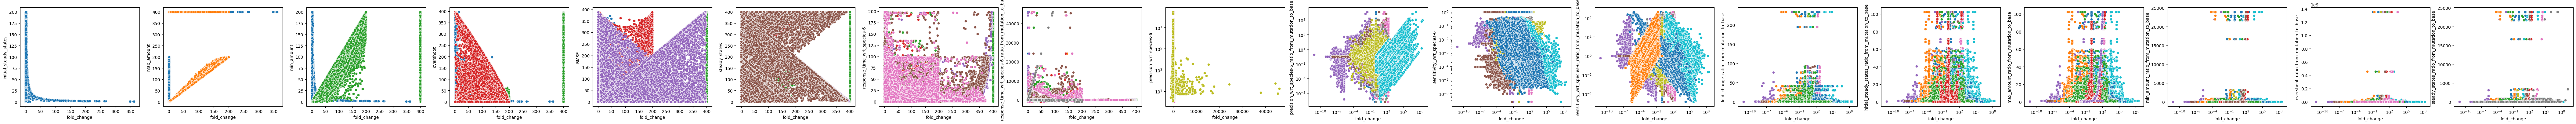

In [ ]:
plt.figure(figsize=(6*len(analytics_types), 5*len(analytics_types)))
for i, ai in enumerate(analytics_types):
    for j, aj in enumerate(analytics_types[i:]):
        if ai == aj:
            continue
        ax = plt.subplot(len(analytics_types), len(analytics_types), i+j)
        sns.scatterplot(data, x=ai, y=aj)
        if np.sum([a in ai for a in ['sensitivity', 'precision']]):
            plt.xscale('log')
        if np.sum([a in aj for a in ['sensitivity', 'precision']]):
            plt.yscale('log')